In [7]:
import re

import pandas as pd
import re, string
import numpy as np
import matplotlib.pyplot as plt
import spacy

from pathlib import Path
from collections import Counter
from multiprocessing import Pool
from urllib.parse import urlparse

from gensim.corpora import Dictionary
from gensim.models.tfidfmodel import TfidfModel
from gensim.matutils import sparse2full

%matplotlib inline

In [8]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer, MultiLabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LinearRegression

In [9]:
path = Path('Data/')

In [10]:
df = pd.read_feather('Data/May2015_subset.fthr')

/anaconda3/envs/ml/lib/python3.6/site-packages/pandas/io/feather_format.py:112: FutureWarning: `nthreads` argument is deprecated, pass `use_threads` instead
  return feather.read_dataframe(path, nthreads=nthreads)


In [11]:
df.subreddit.value_counts()

leagueoflegends      1223184
funny                 745916
news                  548287
todayilearned         519910
worldnews             490354
movies                376601
gaming                361265
politics              244927
explainlikeimfive     223148
anime                 221118
gameofthrones         191006
motorcycles            89721
science                89413
conspiracy             78349
tf2                    76549
sex                    74912
guns                   61234
comicbooks             60303
pokemon                59730
food                   55231
starcraft              53797
askscience             53017
mylittlepony           44119
space                  42726
skyrim                 40568
circlejerk             30134
facepalm               22562
community              20635
harrypotter            19998
progresspics           13385
drunk                  13027
startrek               12275
thewalkingdead         10357
offbeat                10035
lifehacks     

## Focus on 5 subreddits only

In [12]:
subreddit_list = ['worldnews', 'movies', 'gaming', 'science', 'food']

In [13]:
df = df[df.subreddit.isin(subreddit_list)]

In [14]:
df.shape

(1372864, 22)

## Make sure categorical variables are of categorical types

In [10]:
df['subreddit'] = df.subreddit.astype('category')
df['subreddit_id'] = df.subreddit_id.astype('category')
df['distinguished'] = df.distinguished.astype('category')
df['link_id'] = df.link_id.astype('category')

df.drop(['archived', 'retrieved_on', 'id',
         'author_flair_css_class', 'author_flair_text',
         'removal_reason'], axis=1, inplace=True)

In [15]:
df.distinguished.replace(to_replace=np.NaN, value='user', inplace=True)

# EDA

In [23]:
import seaborn as sns

In [18]:
df.head(5).T

,732330,732331,732332,732333,732334
created_utc,1430438556,1430438571,1430438572,1430438623,1430438641
ups,4,2,2,1,1
subreddit_id,t5_2qh55,t5_2qh55,t5_2qh55,t5_2qh55,t5_2qh55
link_id,t3_34gagr,t3_34dogt,t3_34drd4,t3_34gnav,t3_34drd4
name,t1_cqugc7x,t1_cqugcj4,t1_cqugcjl,t1_cqugdly,t1_cqugdz8
score_hidden,0,0,0,0,0
author_flair_css_class,None,None,None,None,None
author_flair_text,None,None,None,None,None
subreddit,food,food,food,food,food
id,cqugc7x,cqugcj4,cqugcjl,cqugdly,cqugdz8


In [19]:
df.columns

Index(['created_utc', 'ups', 'subreddit_id', 'link_id', 'name', 'score_hidden',
       'author_flair_css_class', 'author_flair_text', 'subreddit', 'id',
       'removal_reason', 'gilded', 'downs', 'archived', 'author', 'score',
       'retrieved_on', 'body', 'distinguished', 'edited', 'controversiality',
       'parent_id'],
      dtype='object')

In [20]:
f"{df.memory_usage(deep=True).sum() / 1023.0**3} GB"

'1.1661081546498158 GB'

In [21]:
assert len(df.subreddit_id.unique()) == len(df.subreddit.unique())

In [69]:
df.subreddit.value_counts()

worldnews    490354
movies       376601
gaming       361265
science       89413
food          55231
Name: subreddit, dtype: int64

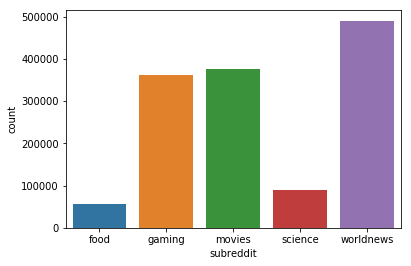

In [26]:
sns.countplot(data=df, x='subreddit')

In [59]:
print("max, min, mean in each subreddit:")
for subreddit in subreddit_list:
    ups = df['ups'][df['subreddit']==subreddit]
    print(f"In {subreddit} \t: max = {max(ups)}, min = {min(ups)}, mean = {ups.mean()}")

max, min, mean in each subreddit:
In worldnews 	: max = 5387, min = -280, mean = 7.400424999082295
In movies 	: max = 4447, min = -549, mean = 9.400118427725896
In gaming 	: max = 5116, min = -812, mean = 8.862787704316776
In science 	: max = 4095, min = -203, mean = 7.209175399550401
In food 	: max = 3307, min = -239, mean = 4.697742209990766


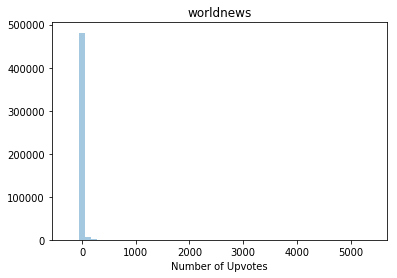

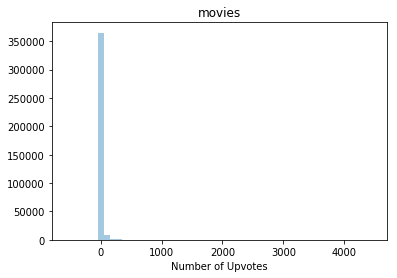

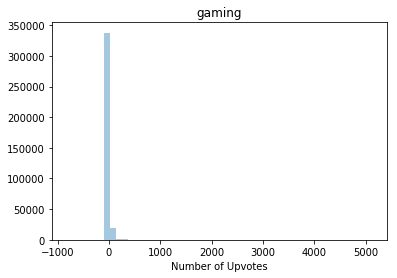

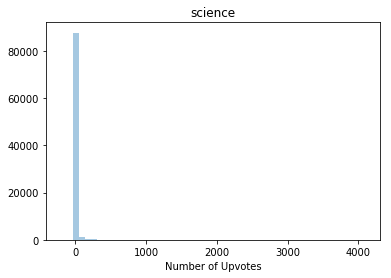

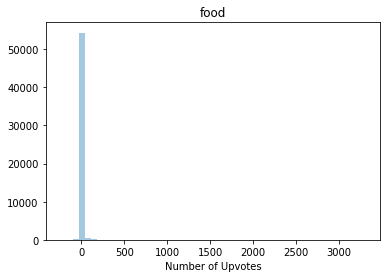

In [65]:
for subreddit in subreddit_list:
    fig, ax = plt.subplots()
    sns.distplot(df['ups'][df['subreddit']==subreddit], kde=False)
    ax.set(xlabel='Number of Upvotes',
      title=subreddit)
    plt.show()

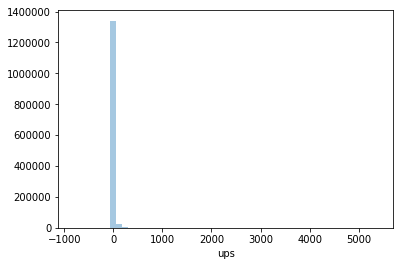

In [66]:
sns.distplot(df['ups'], kde=False)

In [73]:
df['upvoted'] = 'no'
df.loc[df['ups'] != 0, 'upvoted'] = 'yes'

In [80]:
df['upvoted'].value_counts()/df.shape[0]

yes    0.924975
no     0.075025
Name: upvoted, dtype: float64

In [81]:
df['downvoted'] = 'no'
df.loc[df['downs'] != 0, 'downvoted'] = 'yes'
df['downvoted'].value_counts()/df.shape[0]

no    1.0
Name: downvoted, dtype: float64

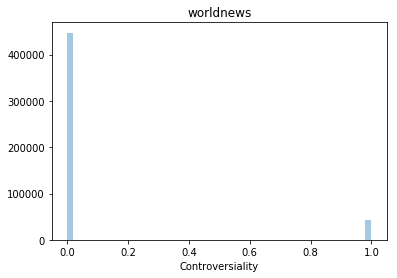

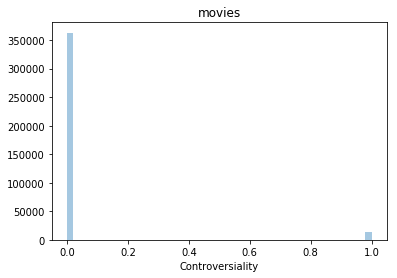

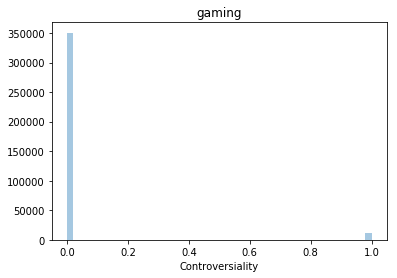

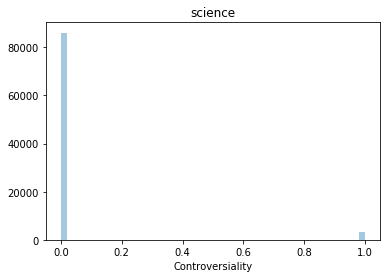

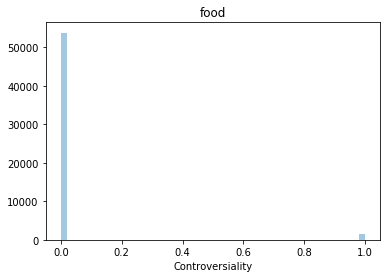

In [64]:
for subreddit in subreddit_list:
    fig, ax = plt.subplots()
    sns.distplot(df['controversiality'][df['subreddit']==subreddit], kde=False)
    ax.set(xlabel='Controversiality',
#       xlim=(-300,300),
      title=subreddit)
    plt.show()

# Engineer new features

In [97]:
df['time'] = pd.to_datetime(df.created_utc, unit='s')

In [98]:
df_first_comment = df[['link_id', 'time']].groupby(by=['link_id']).min()

In [100]:
df_first_comment_dict = df_first_comment.to_dict('index')

In [101]:
def time_lapse(x):
    return df_first_comment_dict[x]['time']

In [102]:
df['time_lapse'] = df.time - df['link_id'].apply(time_lapse)

In [103]:
df.time_lapse = df.time_lapse.apply(lambda x: x.total_seconds())

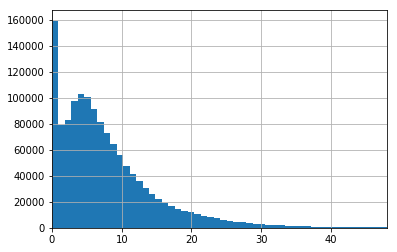

In [104]:
(df.time_lapse / (60*60)).hist(bins=800).set_xlim((0, 48));

In [108]:
def pd_to_dict(df, index='', column=''):
    return pd.Series(df[column].values, index=df[index]).to_dict()

In [109]:
comment_to_parent_dict = pd_to_dict(df[['name', 'parent_id']],
                                    index='name', column='parent_id')

In [111]:
def get_depth(x):
    counter = 0
    temp = x
    while True:  # recursive function to trace to the parent with starts with 't3_'
        if temp[:3] == 't3_':
            return counter
        try:
            temp = comment_to_parent_dict[temp]
        except KeyError:
            return np.nan
        counter += 1

In [112]:
df['depth'] = df['name'].apply(get_depth)

In [113]:
df.depth.isna().sum() / float(df.shape[0])

0.01057424479045266

Most comments are fewer than 10 levels from the parent comment.

In [175]:
df_depth = df[df['depth'].isna() == False]

/anaconda3/envs/ml/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


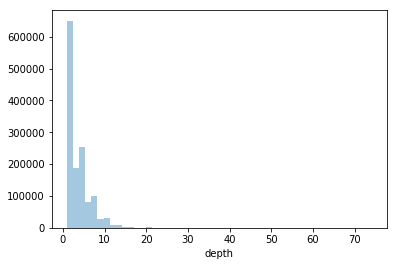

In [176]:
sns.distplot(df_depth['depth'], kde=False)

In [191]:
def get_time_since_parent(pi):
    try:
        return comment_to_time[pi]
    except:
        return np.nan

In [192]:
df['time_since_parent'] = df.parent_id.apply(get_time_since_parent)

In [193]:
df.loc[df.time_since_parent.isna(), 'time_since_parent'] = df.time

In [194]:
df.time_since_parent = df.time - df.time_since_parent

In [195]:
df.time_since_parent = df.time_since_parent.apply(lambda x: x.total_seconds())

In [196]:
df['time_since_parent'].max()

2634310.0

/anaconda3/envs/ml/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


[(0, 2634310.0)]

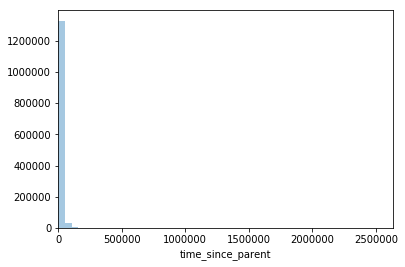

In [182]:
fig, ax = plt.subplots()
sns.distplot(df['time_since_parent'], kde=False, ax=ax)
ax.set(xlim=(0,df['time_since_parent'].max()))

In [147]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [153]:
analyser = SentimentIntensityAnalyzer()

In [154]:
def get_sentiment(x):
    return analyser.polarity_scores(x)

In [155]:
num_partitions = 100
num_cores = 6

In [156]:
def parallelize_dataframe(df, func):
    df_split = np.array_split(df, num_partitions)
    pool = Pool(num_cores)
    df = pd.concat(pool.map(func, df_split))
    pool.close()
    pool.join()
    return df

In [157]:
def wrapper_get_sentiment(df):
    df['sentiment'] = df['body'].apply(get_sentiment)
    return df

In [164]:
sentiment = parallelize_dataframe(df['body'].to_frame(), wrapper_get_sentiment)

In [165]:
sentiment.drop(['body'], axis=1, inplace=True)

In [166]:
df['senti_neg'] = sentiment['sentiment'].apply(lambda x: x['neg'])
df['senti_neu'] = sentiment['sentiment'].apply(lambda x: x['neu'])
df['senti_pos'] = sentiment['sentiment'].apply(lambda x: x['pos'])
df['senti_comp'] = sentiment['sentiment'].apply(lambda x: x['compound'])

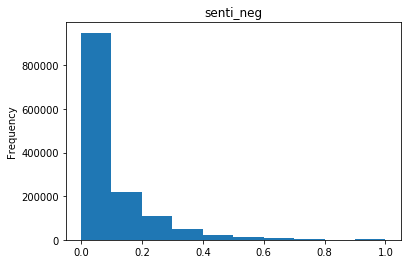

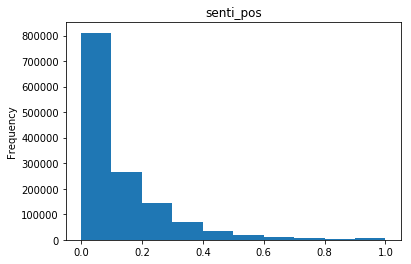

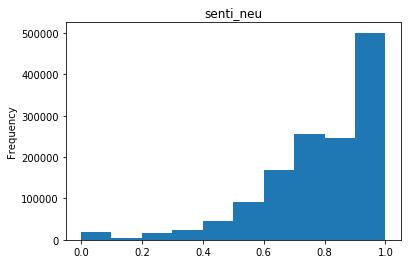

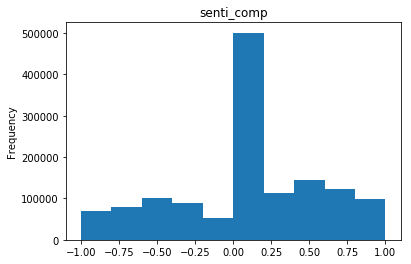

In [202]:
for senti in 'senti_neg senti_pos senti_neu senti_comp'.split():
    fig, ax = plt.subplots()
    df[senti].plot.hist()
    ax.set(title=senti)
    plt.show()

In [167]:
del sentiment

In [168]:
df.to_pickle('Data/working_sub.pkl')

In [169]:
df = pd.read_pickle('Data/working_sub.pkl')

In [197]:
df.shape

(1372864, 42)

In [72]:
# sub_punct = lambda x: re.sub(r'['+string.punctuation+']+', ' ', x)
# df['body'] = df['body'].apply(sub_punct)

In [205]:
def get_word_count(df):
    df['word_count'] = df['body'].apply(lambda x: len(x.split()))
    return df

In [206]:
word_counts = parallelize_dataframe(df['body'].to_frame(), get_word_count)
df['word_counts'] = word_counts.word_count

In [207]:
del word_counts

In [208]:
import string

In [209]:
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS

In [210]:
table = str.maketrans({key: ' ' for key in string.digits + string.punctuation + '\t\n\r'})

In [211]:
def load_glove(filename):
    glove = {}
    with open(filename, 'r') as read_file:
        for line in read_file:
            key = line.split(' ')[0]
            vector = np.array(line.split(' ')[1:], dtype=np.float)
            glove[key] = vector

    return glove

In [212]:
def words(text):
    text = text.lower()
    text = text.translate(table).strip()
    terms = text.split(' ')
    terms = [t for t in terms if len(t) > 2]
    terms = [t for t in terms if t not in ENGLISH_STOP_WORDS]

    return terms

In [237]:
def get_doc2vec(text, gloves):
    count_words = 0
    final_vector = 0
    terms = words(text)

    for t in terms:
        if t in gloves.keys():
            count_words += 1
            final_vector += gloves[t]
    if count_words != 0:
        return final_vector / count_words
    else:
        return None

In [218]:
gloves = load_glove('/Users/haivule/data/glove/glove.6B.50d.txt')

In [238]:
def wrapper_get_centroid(df):
    df['doc2vec'] = df['body'].apply(lambda x: get_doc2vec(x, gloves))
    return df

In [220]:
doc2vec = parallelize_dataframe(df['body'].to_frame(), wrapper_get_centroid)

In [221]:
doc2vec = doc2vec.doc2vec.values

In [222]:
df['doc2vec'] = doc2vec

In [236]:
type(doc2vec)

numpy.ndarray

In [101]:
#vectorizer = TfidfVectorizer()
#X_tfidf = vectorizer.fit_transform(df['body'])

In [227]:
# nlp  = spacy.load('en_core_web_md')

In [234]:
def keep_token(t):
    try:
        return (t.is_alpha and 
                not (t.is_space or t.is_punct or 
                     t.is_stop or t.like_num))
    except:
        return False


# def lemmatize_doc(doc):
#     return [ t.lemma_ for t in doc if keep_token(t)]


# def wrapper_get_lemmatized(df):
#     df['lemmatized_text'] = df['body'].apply(lambda x: lemmatize_doc(nlp(x)))
#     return df

In [225]:
# def doc2vec_lemma(text_lemma, gloves):
#     count_words = 0
#     final_vector = 0

#     for t in text_lemma:
#         if t in gloves.keys():
#             count_words += 1
#             final_vector += gloves[t]
#     if count_words != 0:
#         return final_vector / count_words
#     else:
#         return None

# def wrapper_get_lemma_centroid(df):
#     df['lemma2vec'] = df['lemi'].apply(lambda x: doc2vec_lemma(x, gloves))
#     return df

In [243]:
def get_cosine_angle(cmnt_id):
    child = comment_to_body[cmnt_id]
    try:
        parent = comment_to_body[comment_to_parent[cmnt_id]]
    except KeyError:
        return None
    child = get_doc2vec(child, gloves)
    parent = get_doc2vec(parent, gloves)
    if child is None:
        return None
    if parent is None:
        return None
    return child.dot(parent)

# def get_cosine_angle_lemmas(cmnt_id):
#     child = comment_to_lemi[cmnt_id]
#     try:
#         parent = comment_to_lemi[comment_to_parent[cmnt_id]]
#     except KeyError:
#         return None
#     child = doc2vec_lemma(child, gloves)
#     parent = doc2vec_lemma(parent, gloves)
#     if child is None:
#         return None
#     if parent is None:
#         return None
#     return child.dot(parent)

In [231]:
df.name.values[-10:]

array(['t1_crrbdt2', 't1_crrbdtt', 't1_crrbdvn', 't1_crrbdxj',
       't1_crrbdxr', 't1_crrbebf', 't1_crrbecs', 't1_crrbedn',
       't1_crrbefm', 't1_crrbeft'], dtype=object)

In [244]:
get_cosine_angle('t1_crrbdvn')

6.900523655555543

In [245]:
def wrapper_get_cosine(df):
    df['cosine_angle'] = df['name'].apply(get_cosine_angle)
    return df

# def wrapper_get_cosine_lemma(df):
#     df['cosine_angle_lemma'] = df['name'].apply(get_cosine_angle_lemmas)
#     return df

In [246]:
cosine_angle = parallelize_dataframe(df['name'].to_frame(), wrapper_get_cosine)

In [247]:
df['cos_angle'] = cosine_angle.cosine_angle

In [248]:
cosine_angle_lemma = parallelize_dataframe(df['name'].to_frame(), wrapper_get_cosine_lemma)

NameError: name 'wrapper_get_cosine_lemma' is not defined

In [ ]:
df['cos_angle_lemma'] = cosine_angle_lemma.cosine_angle_lemma

In [205]:
import gc
gc.collect()

1079

In [206]:
df.word_counts.quantile(0.99)

215.0

In [249]:
# remove comments that have  more than 500 words (outliers)
df = df[df['word_counts'] < 250]

In [250]:
df = df[~df.depth.isna()]

In [251]:
df.drop(['score_hidden'], axis=1, inplace=True)

In [252]:
df = df[df.body != '[deleted]']
df = df[df.body != '[removed]']
df = df[df.body != '']

In [253]:
df['linked_sr'] = df.body.apply(lambda x: re.findall(r"/r/([^\s/]+)", x))

In [254]:
df['body'] = df.body.apply(lambda x: re.sub(r"(/r/[^\s/]+)", '', x))

In [255]:
url_regex = r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'

In [256]:
def get_domains(x):
    x = x.replace(' = ', '=')
    x = x.replace(' : ', ':')
    x = x.replace(' / ', '?')
    urls = re.findall(url_regex, x)
    try:
        domain_names = [urlparse(url).netloc.split('.')[-2] for url in urls]
    except:
        return []
    return domain_names

In [257]:
df['linked_urls'] = df.body.apply(lambda x: get_domains(x))

In [258]:
def remove_urls(x):
    x = x.replace(' = ', '=')
    x = x.replace(' : ', ':')
    x = x.replace(' / ', '?')
    return re.sub(url_regex, '', x)

In [259]:
df['body'] = df.body.apply(lambda x: remove_urls(x))

In [260]:
df['no_of_linked_sr'] = df['linked_sr'].apply(lambda x: len(x))
df['no_of_linked_urls'] = df['linked_urls'].apply(lambda x: len(x))

In [261]:
all_linked_sr = []
for l in df.linked_sr.values:
    all_linked_sr += l
len(all_linked_sr)

0

In [262]:
top_sr_links = Counter(all_linked_sr)
top_sr_links.most_common(20)

[]

Should not probably use the actual names.

In [263]:
all_linked_urls = []
for l in df.linked_urls.values:
    all_linked_urls += l
len(all_linked_urls)

0

In [264]:
top_url_links = Counter(all_linked_urls)
top_url_links.most_common(15)

[]

In [265]:
allowed_urls = [i[0] for i in top_url_links.most_common(15)]

In [266]:
def remove_urls(x):
    y = []
    for i in x:
        if i in allowed_urls:
            y += [i]
    return y

In [267]:
df['a_linked_urls'] = df['linked_urls'].apply(lambda x: remove_urls(x))

Small i doesn't work for subjectivity

In [268]:
df['subjectivity'] = df['body'].str.count('I ')

In [269]:
df['is_edited'] = df.edited.apply(lambda x: x > 0)

In [270]:
f"{df.memory_usage(deep=True).sum() / 1023.0**3} GB"

'2.007327194193492 GB'

To check if the comment is quotes another comment.

In [271]:
# if the comment is qouted
df['is_quoted'] = df.body.str.contains('&gt;')

In [272]:
df['no_quoted'] = df.body.str.count('&gt;')

In [138]:
comment_to_score = pd_to_dict(df[['name', 'score']],
                              index='name', column='score')

In [139]:
def get_parent_score(x):
    try:
        return comment_to_score[x]
    except:
        return 0

In [140]:
df['parent_score'] = df.parent_id.apply(lambda x: get_parent_score(x))

In [141]:
comment_to_time = pd_to_dict(df[['name', 'time']],
                              index='name', column='time')

In [212]:
df = df[~df.lemma2vec.isna()]

In [213]:
df = df[~df.cos_angle_lemma.isna()]

In [214]:
df.shape

(846912, 37)

In [215]:
df.columns

Index(['created_utc', 'ups', 'subreddit_id', 'link_id', 'name', 'subreddit',
       'gilded', 'downs', 'author', 'score', 'body', 'distinguished', 'edited',
       'controversiality', 'parent_id', 'time', 'time_lapse', 'depth',
       'linked_sr', 'linked_urls', 'no_of_linked_sr', 'no_of_linked_urls',
       'a_linked_urls', 'subjectivity', 'is_edited', 'is_quoted', 'no_quoted',
       'parent_score', 'time_since_parent', 'senti_neg', 'senti_neu',
       'senti_pos', 'senti_comp', 'word_counts', 'lemi', 'lemma2vec',
       'cos_angle_lemma'],
      dtype='object')

In [216]:
df.drop(['lemma2vec'], inplace=True, axis=1)

In [69]:
df.to_pickle('Data/temp.pkl')

In [6]:
df = pd.read_pickle('Data/temp.pkl')

In [68]:
f"{df.memory_usage(deep=True).sum() / 1023.0**3} GB"

'0.6573981436695813 GB'

In [33]:
lemma2vec = np.vstack([i for i in df.lemma2vec.values])

In [49]:
np.save('Data/lemma2vec.npy', lemma2vec)

In [34]:
df.drop(['lemma2vec'], inplace=True, axis=1)

In [217]:
df.columns

Index(['created_utc', 'ups', 'subreddit_id', 'link_id', 'name', 'subreddit',
       'gilded', 'downs', 'author', 'score', 'body', 'distinguished', 'edited',
       'controversiality', 'parent_id', 'time', 'time_lapse', 'depth',
       'linked_sr', 'linked_urls', 'no_of_linked_sr', 'no_of_linked_urls',
       'a_linked_urls', 'subjectivity', 'is_edited', 'is_quoted', 'no_quoted',
       'parent_score', 'time_since_parent', 'senti_neg', 'senti_neu',
       'senti_pos', 'senti_comp', 'word_counts', 'cos_angle_lemma'],
      dtype='object')

In [218]:
df.is_quoted.value_counts()

False    799999
True      46913
Name: is_quoted, dtype: int64

In [51]:
df.to_pickle('Data/working_sub_d2v.pkl')

In [5]:
df = pd.read_pickle('Data/working_sub_d2v.pkl')
doc2vec = np.load('Data/doc2vec.npy')

In [65]:
vectorizer = TfidfVectorizer(min_df=30)
#X_tfidf = vectorizer.fit_transform(df['body'])

In [219]:
numeric_cols = ['gilded', 'controversiality', 'time_lapse', 'depth', 'no_of_linked_sr',
                'no_of_linked_urls', 'subjectivity', 'no_quoted', 'parent_score',
                'senti_neg', 'senti_neu', 'senti_pos', 'senti_comp', 'word_counts',
                'time_since_parent', 'cos_angle_lemma']

In [220]:
from scipy.sparse import hstack

In [221]:
lb = LabelBinarizer()
mlb = MultiLabelBinarizer()

y = df.score.values
x = np.hstack((lb.fit_transform(df.subreddit),
               lb.fit_transform(df.distinguished),
               lb.fit_transform(df.is_edited),
               lb.fit_transform(df.is_quoted),
               mlb.fit_transform(df.a_linked_urls),
               df.loc[:, numeric_cols].values))
               #, doc2vec))

In [12]:
del df, doc2vec

In [222]:
np.random.seed(42)

In [223]:
x.shape

(846912, 41)

In [224]:
y.shape

(846912,)

In [225]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2,
                                                    random_state=42)

Things to try:
1. Take cosine between the word to vec for past 2 comments
2. Remove the first comment
3. Try gradient boosting
4. Try getting 

In [226]:
from sklearn.ensemble import RandomForestRegressor

In [227]:
from sklearn.ensemble import GradientBoostingRegressor

In [228]:
m = GradientBoostingRegressor(n_estimators=100, min_samples_leaf=10)
m.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=10,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, n_iter_no_change=None, presort='auto',
             random_state=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

In [229]:
y_predicted = m.predict(X_test)
r2 = r2_score(y_test, y_predicted)
mse = mean_squared_error(y_test, y_predicted)
print(f"R-Sq: {r2:.4}")
print(f"RMSE: {np.sqrt(mse)}")

R-Sq: 0.2618
RMSE: 40.88936138559838


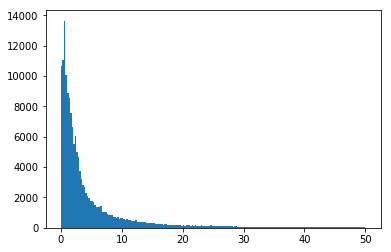

In [36]:
plt.hist(abs(y_test - y_predicted), bins=200, range=[0, 50]);

-------------

In [230]:
m = RandomForestRegressor(n_jobs=-1, n_estimators=40, min_samples_leaf=10)
m.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=10, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [231]:
y_predicted = m.predict(X_test)
r2 = r2_score(y_test, y_predicted)
mse = mean_squared_error(y_test, y_predicted)
print(f"R-Sq: {r2:.4}")
print(f"RMSE: {np.sqrt(mse)}")

R-Sq: 0.2693
RMSE: 40.682850650556034


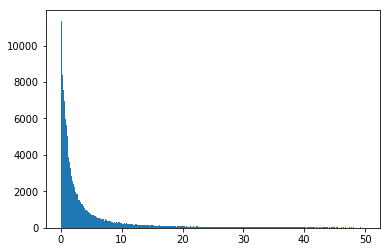

In [28]:
plt.hist(abs(y_test - y_predicted), bins=400, range=[0, 50]);

With raw child 50d glove - with just 10 estimaters

In [47]:
y_predicted = m.predict(X_test)
r2 = r2_score(y_test, y_predicted)
mse = mean_squared_error(y_test, y_predicted)
print(f"R-Sq: {r2:.4}")
print(f"RMSE: {np.sqrt(mse)}")

R-Sq: 0.1107
RMSE: 64.75655527375679


Result with just sentiment and parent score RandomForest 50 estimaters

In [121]:
y_predicted = m.predict(X_test)
r2 = r2_score(y_test, y_predicted)
mse = mean_squared_error(y_test, y_predicted)
print(f"R-Sq: {r2:.4}")
print(f"RMSE: {np.sqrt(mse)}")

R-Sq: 0.1425
RMSE: 60.66416993315583


In [20]:
m = LinearRegression()
m.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [21]:
y_predicted = m.predict(X_test)
r2 = r2_score(y_test, y_predicted)
mse = mean_squared_error(y_test, y_predicted)
print(f"R-Sq: {r2:.4}")
print(f"RMSE: {np.sqrt(mse)}")

R-Sq: 0.07293
RMSE: 66.1184751479385


In [ ]:
dump(m, 'RF.joblib')